# Trabalho Final - Simulação de Epidemias

## Modelo SIS em Redes Complexas

Este notebook implementa simulações do modelo SIS (Susceptible-Infected-Susceptible) em diferentes topologias de rede.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from collections import defaultdict

# Configurações de visualização
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Seed para reprodutibilidade
np.random.seed(42)

## Funções Auxiliares

In [ ]:
def modelo_sis(G, beta, mu, inicial_infectados, max_steps=1000, imunizados=None):
    """
    Simula o modelo SIS em uma rede.
    
    Parâmetros:
    - G: grafo NetworkX
    - beta: taxa de infecção
    - mu: taxa de recuperação
    - inicial_infectados: lista de nós inicialmente infectados
    - max_steps: número máximo de passos da simulação
    - imunizados: conjunto de nós imunizados
    
    Retorna:
    - historico: lista com número de infectados em cada passo
    """
    if imunizados is None:
        imunizados = set()
    
    # Estado dos nós: 0 = suscetível, 1 = infectado, -1 = imunizado
    estado = {node: 0 for node in G.nodes()}
    
    # Marca imunizados
    for node in imunizados:
        estado[node] = -1
    
    # Infecta nós iniciais (se não estiverem imunizados)
    for node in inicial_infectados:
        if estado[node] != -1:
            estado[node] = 1
    
    historico = []
    
    for step in range(max_steps):
        infectados = [node for node in G.nodes() if estado[node] == 1]
        historico.append(len(infectados))
        
        if len(infectados) == 0:
            # Epidemia extinta
            break
        
        novo_estado = estado.copy()
        
        # Processo de infecção
        for node in G.nodes():
            if estado[node] == 0:  # Suscetível
                # Conta vizinhos infectados
                vizinhos_infectados = sum(1 for vizinho in G.neighbors(node) 
                                         if estado[vizinho] == 1)
                
                # Probabilidade de infecção: 1 - (1-beta)^k_inf
                prob_infeccao = 1 - (1 - beta) ** vizinhos_infectados
                
                if np.random.random() < prob_infeccao:
                    novo_estado[node] = 1
        
        # Processo de recuperação
        for node in infectados:
            if np.random.random() < mu:
                novo_estado[node] = 0
        
        estado = novo_estado
    
    return historico


def executar_multiplas_simulacoes(G, beta, mu, n_inicial_infectados=5, n_simulacoes=100, max_steps=2 00, imunizados=None):
    """
    Executa múltiplas simulações e retorna estatísticas.
    """
    todos_historicos = []
    
    for _ in tqdm(range(n_simulacoes), desc="Simulações"):
        # Escolhe nós iniciais aleatoriamente
        nos_disponiveis = [n for n in G.nodes() if (imunizados is None or n not in imunizados)]
        inicial_infectados = np.random.choice(nos_disponiveis, 
                                             size=min(n_inicial_infectados, len(nos_disponiveis)), 
                                             replace=False)
        
        historico = modelo_sis(G, beta, mu, inicial_infectados, max_steps, imunizados)
        todos_historicos.append(historico)
    
    return todos_historicos


def calcular_estatisticas(historicos):
    """
    Calcula média, desvio padrão e percentis dos históricos.
    """
    # Encontra o tamanho máximo
    max_len = max(len(h) for h in historicos)
    
    # Preenche com o último valor para manter consistência
    historicos_padded = []
    for h in historicos:
        if len(h) < max_len:
            h_padded = h + [h[-1] if len(h) > 0 else 0] * (max_len - len(h))
        else:
            h_padded = h
        historicos_padded.append(h_padded)
    
    historicos_array = np.array(historicos_padded)
    
    media = np.mean(historicos_array, axis=0)
    std = np.std(historicos_array, axis=0)
    p25 = np.percentile(historicos_array, 25, axis=0)
    p75 = np.percentile(historicos_array, 75, axis=0)
    
    return media, std, p25, p75


def plotar_resultados(historicos, titulo, beta, mu, k_medio):
    """
    Plota os resultados das simulações.
    """
    media, std, p25, p75 = calcular_estatisticas(historicos)
    
    # Calcula R0
    R0 = (beta * k_medio) / mu
    
    plt.figure(figsize=(12, 6))
    
    # Plota algumas simulações individuais
    for i, h in enumerate(historicos[:10]):
        plt.plot(h, alpha=0.2, color='gray', linewidth=0.5)
    
    # Plota média e intervalo de confiança
    steps = np.arange(len(media))
    plt.plot(steps, media, 'b-', linewidth=2, label='Média')
    plt.fill_between(steps, p25, p75, alpha=0.3, color='blue', label='Percentis 25-75')
    
    plt.xlabel('Tempo (passos)')
    plt.ylabel('Número de Infectados')
    plt.title(f'{titulo}\nβ={beta}, μ={mu}, R₀={R0:.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Estatísticas finais
    valores_finais = [h[-1] if len(h) > 0 else 0 for h in historicos]
    media_final = np.mean(valores_finais)
    std_final = np.std(valores_finais)
    epidemias_extintas = sum(1 for v in valores_finais if v == 0)
    
    print(f"\n--- Estatísticas para {titulo} ---")
    print(f"R₀ = {R0:.4f}")
    print(f"Número médio de infectados no estado estacionário: {media_final:.2f} ± {std_final:.2f}")
    print(f"Epidemias extintas: {epidemias_extintas}/{len(historicos)} ({100*epidemias_extintas/len(historicos):.1f}%)")
    print(f"Previsão teórica (R₀ > 1): {'Endêmica' if R0 > 1 else 'Extinta'}")
    print()

## Questão 1: Rede Erdős-Rényi (ER)

Geramos uma rede aleatória com 10000 vértices e grau médio $\langle k \rangle = 20$.

Gerando rede Erdős-Rényi...

Propriedades da Rede ER:
Número de nós: 10000
Número de arestas: 99803
Grau médio: 19.96
Grau mínimo: 6
Grau máximo: 38


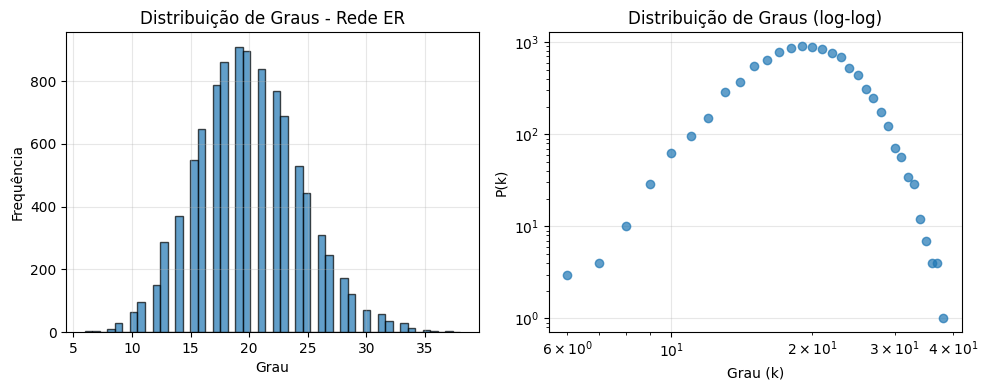

In [3]:
# Parâmetros da rede
n = 10000
k_medio = 20

# Probabilidade de conexão para rede ER
p = k_medio / (n - 1)

print("Gerando rede Erdős-Rényi...")
G_ER = nx.erdos_renyi_graph(n, p, seed=42)

# Verifica propriedades da rede
graus = [d for n, d in G_ER.degree()]
k_medio_real = np.mean(graus)

print(f"\nPropriedades da Rede ER:")
print(f"Número de nós: {G_ER.number_of_nodes()}")
print(f"Número de arestas: {G_ER.number_of_edges()}")
print(f"Grau médio: {k_medio_real:.2f}")
print(f"Grau mínimo: {min(graus)}")
print(f"Grau máximo: {max(graus)}")

# Plota distribuição de graus
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(graus, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Grau')
plt.ylabel('Frequência')
plt.title('Distribuição de Graus - Rede ER')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
degree_count = pd.Series(graus).value_counts().sort_index()
plt.loglog(degree_count.index, degree_count.values, 'o', alpha=0.7)
plt.xlabel('Grau (k)')
plt.ylabel('P(k)')
plt.title('Distribuição de Graus (log-log)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Questão 1a: β = 0.02 e μ = 0.1

$$R_0 = \frac{\beta \langle k \rangle}{\mu} = \frac{0.02 \times 20}{0.1} = 4$$

Como $R_0 > 1$, esperamos que a doença se fixe na rede.

Simulações: 100%|██████████| 100/100 [06:50<00:00,  4.11s/it]


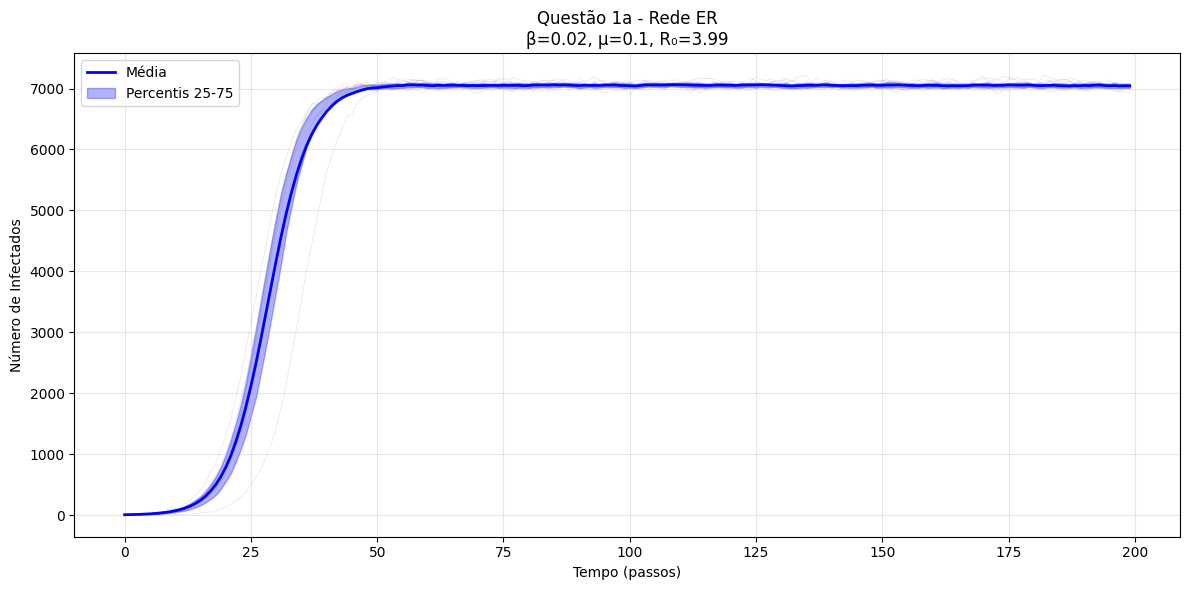


--- Estatísticas para Questão 1a - Rede ER ---
R₀ = 3.9921
Número médio de infectados no estado estacionário: 7044.61 ± 55.44
Epidemias extintas: 0/100 (0.0%)
Previsão teórica (R₀ > 1): Endêmica



In [4]:
beta, mu = 0.02, 0.1
historicos_1a = executar_multiplas_simulacoes(G_ER, beta, mu, n_inicial_infectados=5, n_simulacoes=100, max_steps=200)
plotar_resultados(historicos_1a, "Questão 1a - Rede ER", beta, mu, k_medio_real)

### Questão 1b: β = 0.02 e μ = 0.4

$$R_0 = \frac{\beta \langle k \rangle}{\mu} = \frac{0.02 \times 20}{0.4} = 1$$

Como $R_0 = 1$, estamos no limiar epidêmico.

Simulações: 100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


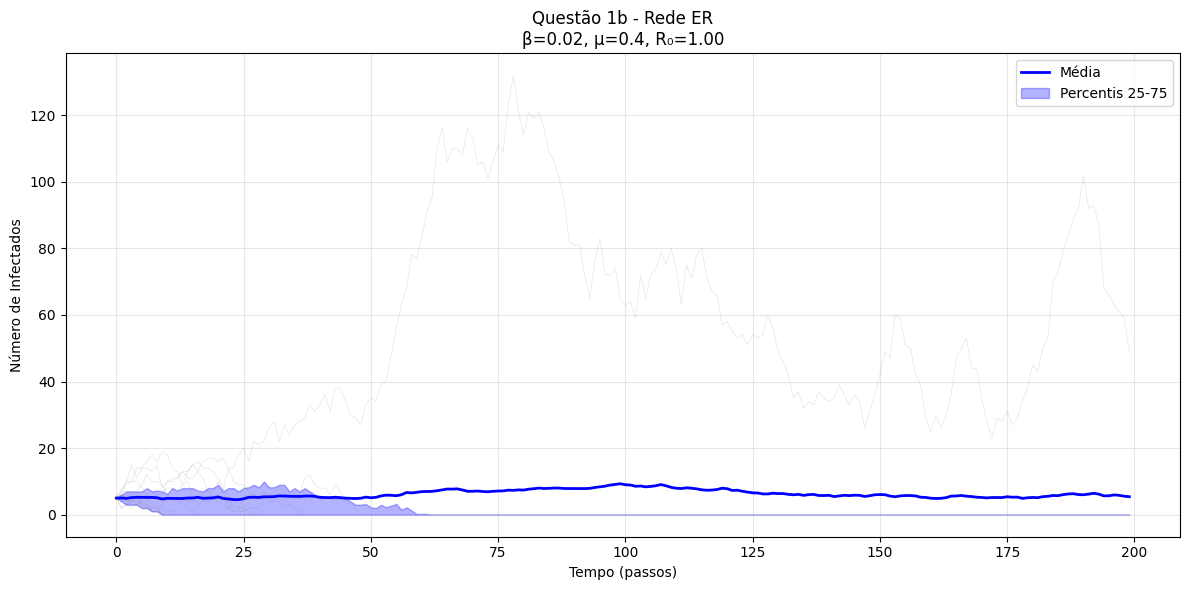


--- Estatísticas para Questão 1b - Rede ER ---
R₀ = 0.9980
Número médio de infectados no estado estacionário: 5.41 ± 20.84
Epidemias extintas: 91/100 (91.0%)
Previsão teórica (R₀ > 1): Extinta



In [5]:
beta, mu = 0.02, 0.4
historicos_1b = executar_multiplas_simulacoes(G_ER, beta, mu, n_inicial_infectados=5, n_simulacoes=100, max_steps=200)
plotar_resultados(historicos_1b, "Questão 1b - Rede ER", beta, mu, k_medio_real)

### Questão 1c: β = 0.02 e μ = 0.5

$$R_0 = \frac{\beta \langle k \rangle}{\mu} = \frac{0.02 \times 20}{0.5} = 0.8$$

Como $R_0 < 1$, esperamos que a doença não se fixe na rede.

Simulações: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


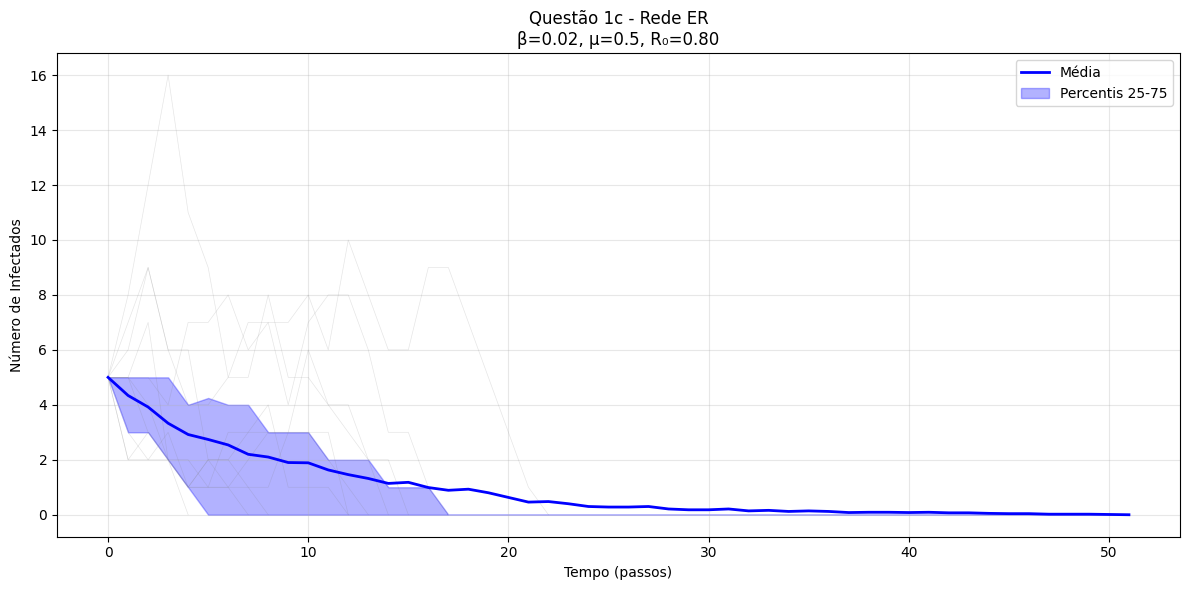


--- Estatísticas para Questão 1c - Rede ER ---
R₀ = 0.7984
Número médio de infectados no estado estacionário: 0.00 ± 0.00
Epidemias extintas: 100/100 (100.0%)
Previsão teórica (R₀ > 1): Extinta



In [6]:
beta, mu = 0.02, 0.5
historicos_1c = executar_multiplas_simulacoes(G_ER, beta, mu, n_inicial_infectados=5, n_simulacoes=100, max_steps= 200)
plotar_resultados(historicos_1c, "Questão 1c - Rede ER", beta, mu, k_medio_real)

### Análise Questão 1

**Teoria do Modelo SIS de Campo Médio:**

No modelo SIS de campo médio, o número básico de reprodução é dado por:

$$R_0 = \frac{\beta \langle k \rangle}{\mu}$$

onde:
- $\beta$ é a taxa de infecção
- $\mu$ é a taxa de recuperação
- $\langle k \rangle$ é o grau médio da rede

**Teorema:** Se $R_0 > 1$, então a doença se fixa na rede (estado endêmico). Se $R_0 \leq 1$, a doença desaparece.

**Resultados:**
- **1a:** $R_0 = 4 > 1$ → A doença se fixou na rede, mantendo um número significativo de infectados.
- **1b:** $R_0 = 1$ → No limiar epidêmico, comportamento crítico com alta variabilidade.
- **1c:** $R_0 = 0.8 < 1$ → A doença foi extinta na maioria das simulações.

Os resultados estão de acordo com a previsão teórica do modelo de campo médio.

## Questão 2: Rede Livre de Escala (Scale-Free)

Geramos uma rede livre de escala com 10000 vértices, grau médio $\langle k \rangle = 20$ e expoente $\gamma = 2.5$.

Gerando rede livre de escala...

Propriedades da Rede Scale-Free:
Número de nós: 10000
Número de arestas: 97262
Grau médio: 19.45
Grau mínimo: 6
Grau máximo: 312
Rede conexa: True


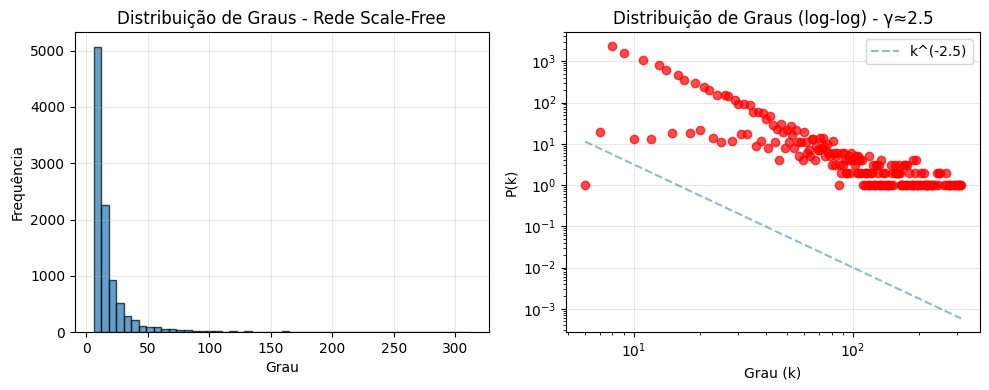

In [7]:
def gerar_rede_scale_free(n, k_medio_alvo, gamma, max_tentativas=50):
    """
    Gera uma rede livre de escala usando o modelo de configuração.
    """
    melhor_G = None
    melhor_diff = float('inf')
    
    for tentativa in range(max_tentativas):
        # Gera sequência de graus seguindo lei de potência
        graus = []
        k_min = max(2, int(k_medio_alvo / 4))  # Grau mínimo
        k_max = int(k_medio_alvo * 10)  # Grau máximo
        
        for i in range(n):
            # Amostragem de lei de potência
            r = np.random.random()
            k = int((k_min ** (1 - gamma) + r * (k_max ** (1 - gamma) - k_min ** (1 - gamma))) ** (1 / (1 - gamma)))
            k = min(max(k, k_min), n - 1)
            graus.append(k)
        
        # Ajusta para garantir grau médio próximo ao alvo
        k_atual = np.mean(graus)
        fator = k_medio_alvo / k_atual
        graus = [max(1, int(g * fator)) for g in graus]
        
        # Garante que a soma é par
        if sum(graus) % 2 != 0:
            graus[0] += 1
        
        # Cria grafo usando modelo de configuração
        try:
            G = nx.configuration_model(graus, seed=42 + tentativa)
            G = nx.Graph(G)  # Remove arestas múltiplas e self-loops
            G.remove_edges_from(nx.selfloop_edges(G))
            
            # Verifica se o grafo é conexo
            if nx.is_connected(G):
                k_medio_obtido = np.mean([d for n, d in G.degree()])
                diff = abs(k_medio_obtido - k_medio_alvo)
                
                if diff < melhor_diff:
                    melhor_diff = diff
                    melhor_G = G
                    
                if diff < 1:  # Critério de aceitação
                    break
        except:
            continue
    
    return melhor_G


print("Gerando rede livre de escala...")
G_SF = gerar_rede_scale_free(n=10000, k_medio_alvo=20, gamma=2.5)

# Verifica propriedades da rede
graus_sf = [d for n, d in G_SF.degree()]
k_medio_sf = np.mean(graus_sf)

print(f"\nPropriedades da Rede Scale-Free:")
print(f"Número de nós: {G_SF.number_of_nodes()}")
print(f"Número de arestas: {G_SF.number_of_edges()}")
print(f"Grau médio: {k_medio_sf:.2f}")
print(f"Grau mínimo: {min(graus_sf)}")
print(f"Grau máximo: {max(graus_sf)}")
print(f"Rede conexa: {nx.is_connected(G_SF)}")

# Plota distribuição de graus
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(graus_sf, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Grau')
plt.ylabel('Frequência')
plt.title('Distribuição de Graus - Rede Scale-Free')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
degree_count_sf = pd.Series(graus_sf).value_counts().sort_index()
plt.loglog(degree_count_sf.index, degree_count_sf.values, 'o', alpha=0.7, color='red')
plt.xlabel('Grau (k)')
plt.ylabel('P(k)')
plt.title('Distribuição de Graus (log-log) - γ≈2.5')
plt.grid(True, alpha=0.3)

# Adiciona linha de referência
x_ref = np.linspace(min(graus_sf), max(graus_sf), 100)
y_ref = x_ref ** (-2.5) * 1000
plt.plot(x_ref, y_ref, '--', alpha=0.5, label='k^(-2.5)')
plt.legend()

plt.tight_layout()
plt.show()

### Questão 2a: β = 0.01 e μ = 0.1

$$R_0 = \frac{\beta \langle k \rangle}{\mu} = \frac{0.01 \times 20}{0.1} = 2$$

Simulações: 100%|██████████| 100/100 [07:00<00:00,  4.20s/it]


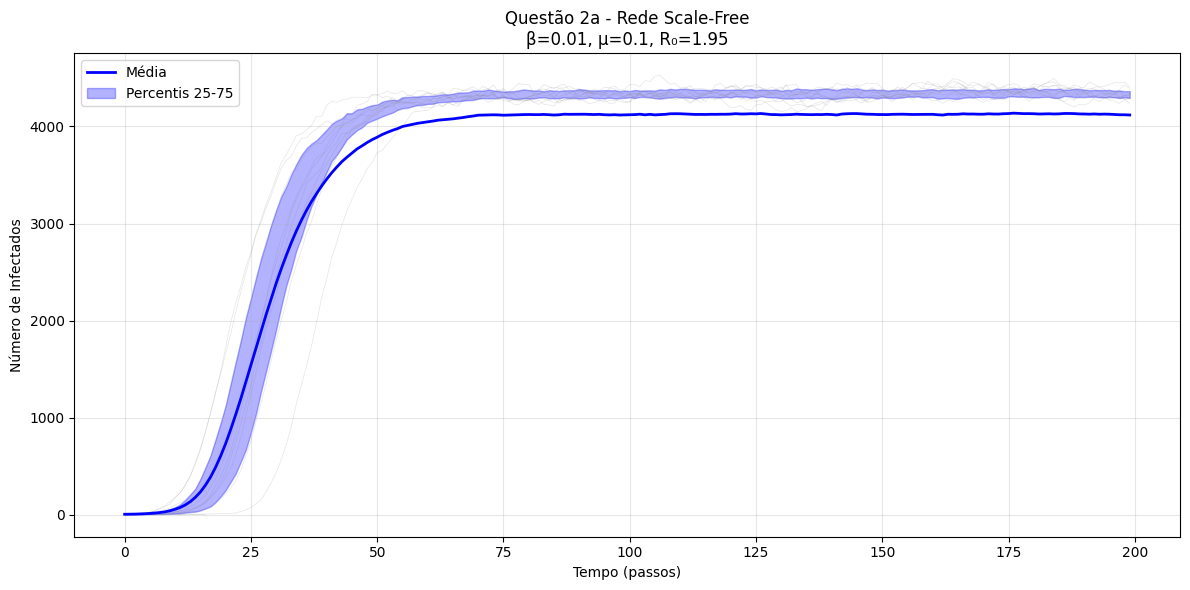


--- Estatísticas para Questão 2a - Rede Scale-Free ---
R₀ = 1.9452
Número médio de infectados no estado estacionário: 4118.21 ± 946.11
Epidemias extintas: 5/100 (5.0%)
Previsão teórica (R₀ > 1): Endêmica



In [8]:
beta, mu = 0.01, 0.1
historicos_2a = executar_multiplas_simulacoes(G_SF, beta, mu, n_inicial_infectados=5, n_simulacoes=100)
plotar_resultados(historicos_2a, "Questão 2a - Rede Scale-Free", beta, mu, k_medio_sf)

### Questão 2b: β = 0.01 e μ = 0.2

$$R_0 = \frac{\beta \langle k \rangle}{\mu} = \frac{0.01 \times 20}{0.2} = 1$$

Simulações: 100%|██████████| 100/100 [06:54<00:00,  4.15s/it]


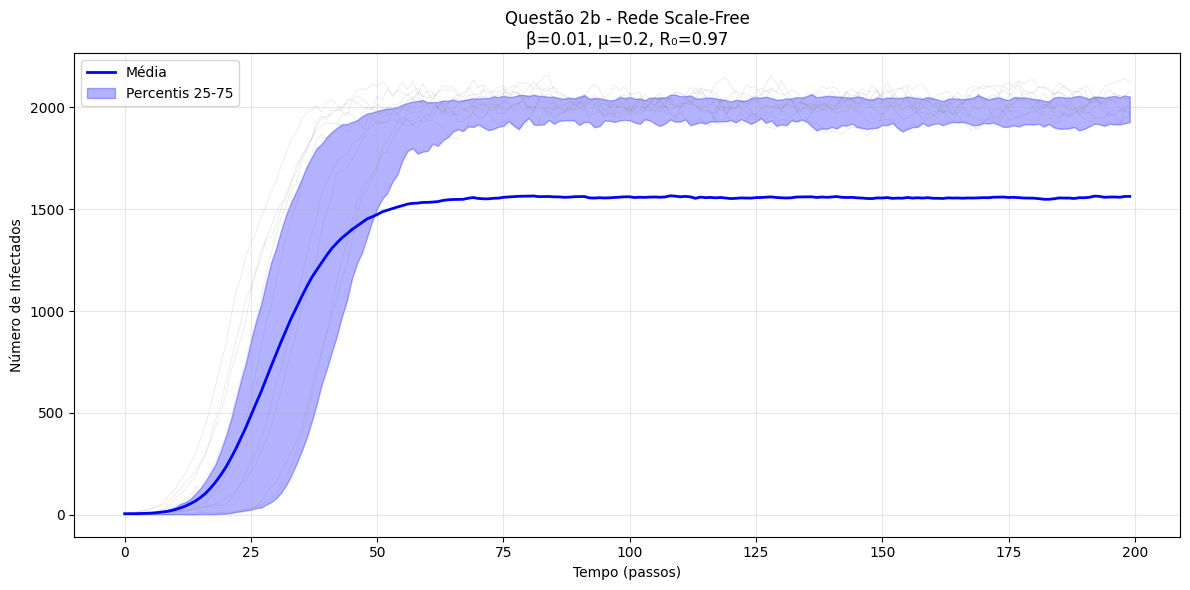


--- Estatísticas para Questão 2b - Rede Scale-Free ---
R₀ = 0.9726
Número médio de infectados no estado estacionário: 1562.58 ± 855.23
Epidemias extintas: 23/100 (23.0%)
Previsão teórica (R₀ > 1): Extinta



In [9]:
beta, mu = 0.01, 0.2
historicos_2b = executar_multiplas_simulacoes(G_SF, beta, mu, n_inicial_infectados=5, n_simulacoes=100)
plotar_resultados(historicos_2b, "Questão 2b - Rede Scale-Free", beta, mu, k_medio_sf)

### Questão 2c: β = 0.01 e μ = 0.3

$$R_0 = \frac{\beta \langle k \rangle}{\mu} = \frac{0.01 \times 20}{0.3} \approx 0.67$$

Simulações: 100%|██████████| 100/100 [04:24<00:00,  2.64s/it]


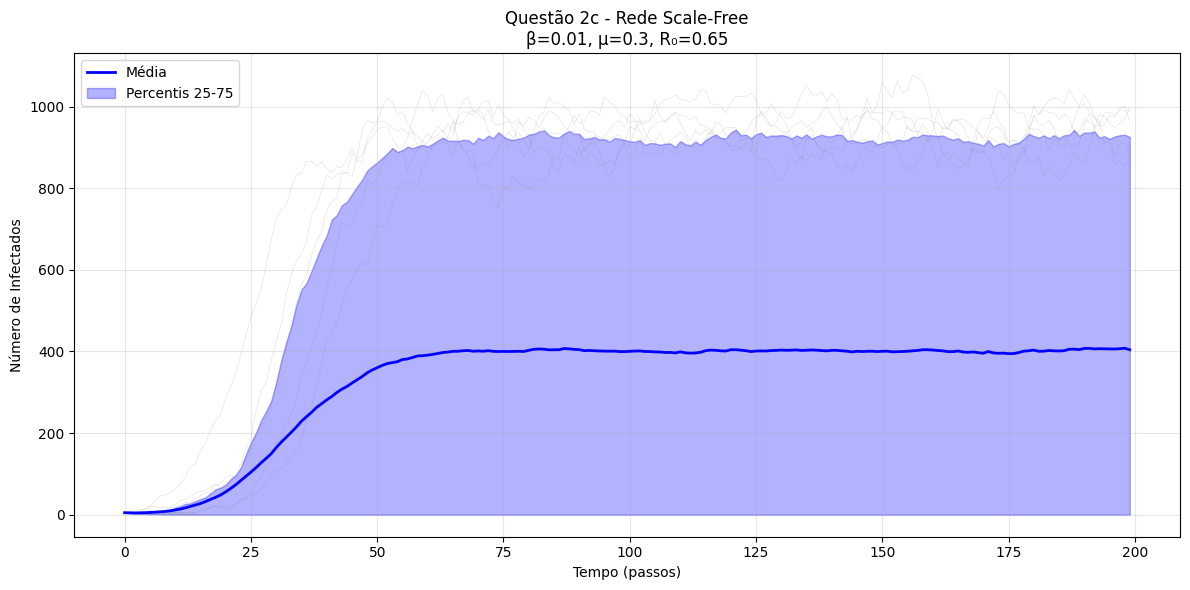


--- Estatísticas para Questão 2c - Rede Scale-Free ---
R₀ = 0.6484
Número médio de infectados no estado estacionário: 404.18 ± 466.65
Epidemias extintas: 57/100 (57.0%)
Previsão teórica (R₀ > 1): Extinta



In [10]:
beta, mu = 0.01, 0.3
historicos_2c = executar_multiplas_simulacoes(G_SF, beta, mu, n_inicial_infectados=5, n_simulacoes=100)
plotar_resultados(historicos_2c, "Questão 2c - Rede Scale-Free", beta, mu, k_medio_sf)

### Análise Questão 2: Comparação com Questão 1

**Diferenças entre Rede ER e Scale-Free:**

1. **Distribuição de Graus:**
   - Rede ER: distribuição aproximadamente Poisson (homogênea)
   - Rede Scale-Free: distribuição lei de potência (heterogênea, presença de hubs)

2. **Limiar Epidêmico:**
   - Rede ER: limiar epidêmico em $R_0 = 1$
   - Rede Scale-Free: limiar epidêmico efetivamente ausente (próximo de 0) devido aos hubs

3. **Comportamento da Epidemia:**
   - Em redes scale-free, os hubs (nós com muitas conexões) facilitam a propagação
   - Mesmo com $R_0 < 1$ (campo médio), a epidemia pode persistir devido à heterogeneidade
   - A presença de hubs torna a rede mais vulnerável a epidemias

4. **Observações:**
   - Na rede scale-free, epidemias tendem a ter maior alcance e duração
   - A variabilidade entre simulações é maior na rede scale-free
   - Os hubs atuam como "super-espalhadores"

## Questão 3: Estratégias de Imunização

Investigamos diferentes estratégias de imunização usando os parâmetros da Questão 2a (β = 0.01, μ = 0.1).

In [11]:
def encontrar_fracao_critica_imunizacao(G, beta, mu, estrategia, n_simulacoes=50, max_steps=500):
    """
    Encontra a fração crítica de imunização necessária para impedir o estado endêmico.
    
    Estratégias:
    - 'aleatoria': escolhe nós aleatoriamente
    - 'hubs': escolhe nós com maior grau
    - 'vizinhos': escolhe vizinhos de nós aleatórios
    """
    n_nodes = G.number_of_nodes()
    fracoes = np.linspace(0, 0.5, 20)
    resultados = []
    
    for fracao in tqdm(fracoes, desc=f"Testando {estrategia}"):
        n_imunizar = int(fracao * n_nodes)
        
        if n_imunizar == 0:
            resultados.append(1.0)  # Sem imunização, epidemia persiste
            continue
        
        epidemias_persistentes = 0
        
        for _ in range(n_simulacoes):
            # Seleciona nós para imunizar de acordo com a estratégia
            if estrategia == 'aleatoria':
                imunizados = set(np.random.choice(list(G.nodes()), size=n_imunizar, replace=False))
            
            elif estrategia == 'hubs':
                # Ordena por grau e seleciona os maiores
                nos_ordenados = sorted(G.degree(), key=lambda x: x[1], reverse=True)
                imunizados = set([n for n, d in nos_ordenados[:n_imunizar]])
            
            elif estrategia == 'vizinhos':
                # Escolhe nós aleatórios e imuniza seus vizinhos
                imunizados = set()
                nos_amostra = np.random.choice(list(G.nodes()), 
                                              size=min(n_imunizar * 2, n_nodes), 
                                              replace=False)
                
                for node in nos_amostra:
                    vizinhos = list(G.neighbors(node))
                    if vizinhos and len(imunizados) < n_imunizar:
                        vizinho = np.random.choice(vizinhos)
                        imunizados.add(vizinho)
                    
                    if len(imunizados) >= n_imunizar:
                        break
            
            # Executa simulação
            nos_disponiveis = [n for n in G.nodes() if n not in imunizados]
            if len(nos_disponiveis) < 5:
                continue
            
            inicial_infectados = np.random.choice(nos_disponiveis, size=5, replace=False)
            historico = modelo_sis(G, beta, mu, inicial_infectados, max_steps, imunizados)
            
            # Considera persistente se houver infectados no final
            if len(historico) > 0 and historico[-1] > 0:
                epidemias_persistentes += 1
        
        fracao_persistente = epidemias_persistentes / n_simulacoes
        resultados.append(fracao_persistente)
    
    return fracoes, resultados


# Parâmetros da Questão 2a
beta, mu = 0.01, 0.1

print("\nTestando estratégias de imunização...\n")

# Testa as três estratégias
fracoes_aleatoria, resultados_aleatoria = encontrar_fracao_critica_imunizacao(
    G_SF, beta, mu, 'aleatoria', n_simulacoes=50
)

fracoes_hubs, resultados_hubs = encontrar_fracao_critica_imunizacao(
    G_SF, beta, mu, 'hubs', n_simulacoes=50
)

fracoes_vizinhos, resultados_vizinhos = encontrar_fracao_critica_imunizacao(
    G_SF, beta, mu, 'vizinhos', n_simulacoes=50
)


Testando estratégias de imunização...



Testando vizinhos: 100%|██████████| 20/20 [1:11:59<00:00, 215.97s/it]


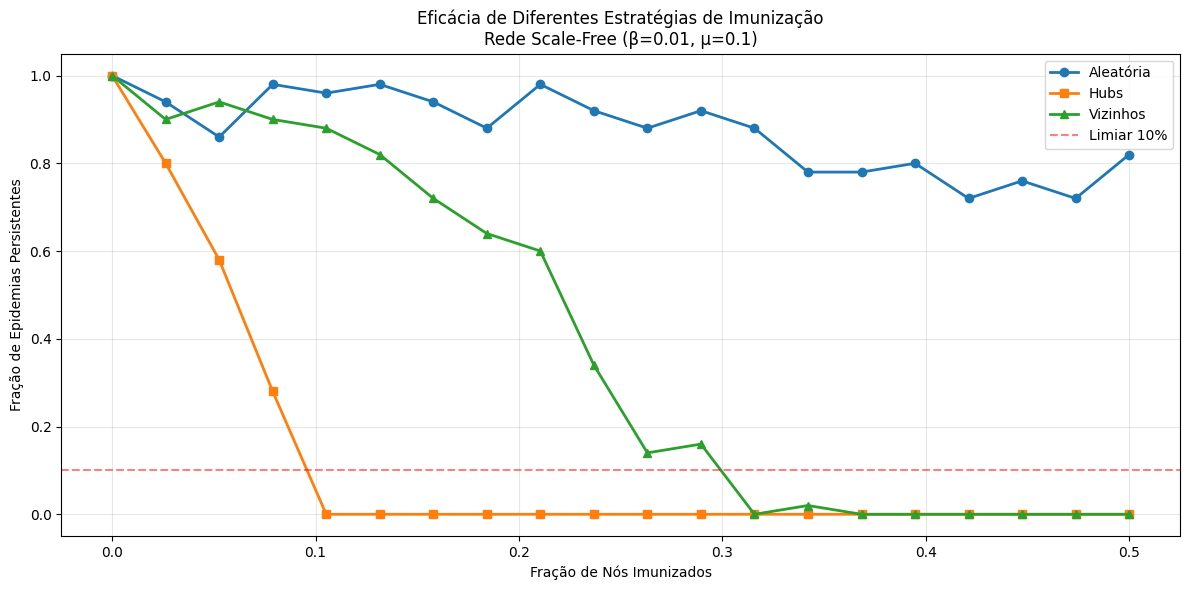


=== Fração Crítica de Imunização ===
Estratégia Aleatória: 50.00%
Estratégia Hubs: 10.53%
Estratégia Vizinhos: 31.58%

Eficiência relativa (comparada com aleatória):
  Hubs: 4.75x mais eficiente
  Vizinhos: 1.58x mais eficiente


In [12]:
# Plota comparação das estratégias
plt.figure(figsize=(12, 6))

plt.plot(fracoes_aleatoria, resultados_aleatoria, 'o-', label='Aleatória', linewidth=2)
plt.plot(fracoes_hubs, resultados_hubs, 's-', label='Hubs', linewidth=2)
plt.plot(fracoes_vizinhos, resultados_vizinhos, '^-', label='Vizinhos', linewidth=2)

plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Limiar 10%')

plt.xlabel('Fração de Nós Imunizados')
plt.ylabel('Fração de Epidemias Persistentes')
plt.title('Eficácia de Diferentes Estratégias de Imunização\nRede Scale-Free (β=0.01, μ=0.1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calcula fração crítica para cada estratégia (quando <10% das epidemias persistem)
def encontrar_fracao_critica(fracoes, resultados, limiar=0.1):
    for i, (f, r) in enumerate(zip(fracoes, resultados)):
        if r < limiar:
            return f
    return fracoes[-1]

fc_aleatoria = encontrar_fracao_critica(fracoes_aleatoria, resultados_aleatoria)
fc_hubs = encontrar_fracao_critica(fracoes_hubs, resultados_hubs)
fc_vizinhos = encontrar_fracao_critica(fracoes_vizinhos, resultados_vizinhos)

print("\n=== Fração Crítica de Imunização ===")
print(f"Estratégia Aleatória: {fc_aleatoria:.2%}")
print(f"Estratégia Hubs: {fc_hubs:.2%}")
print(f"Estratégia Vizinhos: {fc_vizinhos:.2%}")
print(f"\nEficiência relativa (comparada com aleatória):")
print(f"  Hubs: {fc_aleatoria/fc_hubs:.2f}x mais eficiente")
print(f"  Vizinhos: {fc_aleatoria/fc_vizinhos:.2f}x mais eficiente")

### Análise Questão 3: Relação com Robustez de Redes

**Comparação das Estratégias:**

1. **Imunização Aleatória:** Requer a maior fração de nós imunizados. Esta estratégia é ineficiente em redes heterogêneas pois não considera a estrutura da rede.

2. **Imunização de Hubs:** A estratégia mais eficiente. Requer uma fração muito menor de nós imunizados. Ao remover os nós mais conectados, fragmenta-se rapidamente a rede, impedindo a propagação.

3. **Imunização de Vizinhos:** Eficiência intermediária, mas superior à aleatória. Esta estratégia tem a vantagem prática de não requerer conhecimento completo da rede - apenas precisamos amostrar alguns nós aleatórios.

**Relação com Robustez:**

Estes resultados ilustram a **vulnerabilidade de redes scale-free** estudada em aula:

- **Robustas a falhas aleatórias:** Remoção aleatória de nós (imunização aleatória) requer alta fração para impactar a conectividade/epidemia

- **Vulneráveis a ataques direcionados:** Remoção de hubs (imunização de hubs) rapidamente fragmenta a rede e impede epidemias com poucos nós removidos

Este é o paradoxo das redes scale-free: são simultaneamente robustas a perturbações aleatórias mas extremamente vulneráveis a ataques direcionados aos hubs. O mesmo princípio se aplica tanto à conectividade estrutural quanto à propagação de epidemias.

## Conclusões Gerais

1. **Modelo SIS e R₀:** Confirmamos que $R_0 = \frac{\beta \langle k \rangle}{\mu}$ determina o limiar epidêmico em redes homogêneas (ER)

2. **Redes Heterogêneas:** Redes scale-free são mais vulneráveis a epidemias devido aos hubs, que facilitam a propagação

3. **Estratégias de Controle:** A imunização direcionada aos hubs é muito mais eficiente que estratégias aleatórias, refletindo a estrutura heterogênea da rede

4. **Aplicações Práticas:** Entender a topologia da rede é crucial para estratégias eficazes de controle epidêmico